In [ ]:
!git clone https://github.com/gsarridis/vb-mitigator.git
%cd /content/vb-mitigator

fatal: destination path 'vb-mitigator' already exists and is not an empty directory.
/content/vb-mitigator


In [ ]:
%pip install -r requirements.txt

  Cloning https://github.com/xinyu1205/recognize-anything.git to /tmp/pip-req-build-69dt2a8o
  Running command git clone --filter=blob:none --quiet https://github.com/xinyu1205/recognize-anything.git /tmp/pip-req-build-69dt2a8o
  Resolved https://github.com/xinyu1205/recognize-anything.git to commit 7cb804a8609e9f4b1a50b7f31436d2df40bb9481
  Preparing metadata (setup.py) ... done


In [ ]:
# Step 3: download FairFace (images + labels) into data/fairface/
%cd /content/vb-mitigator

# 3a) install gdown (reliable for Google Drive)
%pip install -q gdown

# 3b) make a data dir
import os
os.makedirs("data/fairface", exist_ok=True)

# 3c) download the image zip (train+val, padding=0.25) and the train/val CSVs
# Sources (file IDs) from the official FairFace repo:
#   Images zip: https://drive.google.com/file/d/1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86/view
#   Train CSV : https://drive.google.com/file/d/1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH/view
#   Val CSV   : https://drive.google.com/file/d/1wOdja-ezstMEp81tX1a-EYkFebev4h7D/view

import gdown

img_zip_id = "1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86"
train_csv_id = "1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH"
val_csv_id   = "1wOdja-ezstMEp81tX1a-EYkFebev4h7D"

gdown.download(f"https://drive.google.com/uc?id={img_zip_id}", "data/fairface/fairface-img-margin025-trainval.zip", quiet=False)
gdown.download(f"https://drive.google.com/uc?id={train_csv_id}", "data/fairface/fairface_label_train.csv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id={val_csv_id}",   "data/fairface/fairface_label_val.csv", quiet=False)

# 3d) unzip images
import zipfile
with zipfile.ZipFile("data/fairface/fairface-img-margin025-trainval.zip") as z:
    z.extractall("data/fairface/")

# quick confirmation
import os, glob
img_count = len(glob.glob("data/fairface/fairface-img-margin025-trainval/*/*.jpg"))
print("FairFace images found:", img_count)
print("CSV files present:", os.path.exists("data/fairface/fairface_label_train.csv"), os.path.exists("data/fairface/fairface_label_val.csv"))


/content/vb-mitigator


Downloading...
From (original): https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
From (redirected): https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86&confirm=t&uuid=14a0caf1-1ee1-4850-ad64-67e7fc5be1c7
To: /content/vb-mitigator/data/fairface/fairface-img-margin025-trainval.zip
100%|██████████| 578M/578M [00:04<00:00, 127MB/s]
Downloading...
From: https://drive.google.com/uc?id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH
To: /content/vb-mitigator/data/fairface/fairface_label_train.csv
100%|██████████| 3.79M/3.79M [00:00<00:00, 27.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D
To: /content/vb-mitigator/data/fairface/fairface_label_val.csv
100%|██████████| 448k/448k [00:00<00:00, 4.63MB/s]


FairFace images found: 0
CSV files present: True True


In [ ]:
# Step 5: load the FairFace train and val CSVs into a DataFrame
import pandas as pd

train_df = pd.read_csv("data/fairface/fairface_label_train.csv")
val_df   = pd.read_csv("data/fairface/fairface_label_val.csv")

df = pd.concat([train_df, val_df], ignore_index=True)

print("Total samples:", len(df))
print(df.head())
print("Columns:", df.columns.tolist())

Total samples: 97698
          file    age  gender        race  service_test
0  train/1.jpg  50-59    Male  East Asian          True
1  train/2.jpg  30-39  Female      Indian         False
2  train/3.jpg    3-9  Female       Black         False
3  train/4.jpg  20-29  Female      Indian          True
4  train/5.jpg  20-29  Female      Indian          True
Columns: ['file', 'age', 'gender', 'race', 'service_test']


In [ ]:
# Step 6: summarize gender, race, and age distributions
print("Gender distribution:\n", df["gender"].value_counts(normalize=True).round(3))
print("\nRace distribution:\n", df["race"].value_counts(normalize=True).round(3))
print("\nAge distribution:\n", df["age"].value_counts(normalize=True).round(3).head(10))  # show top 10 buckets

Gender distribution:
 gender
Male      0.53
Female    0.47
Name: proportion, dtype: float64

Race distribution:
 race
White              0.191
Latino_Hispanic    0.153
East Asian         0.142
Indian             0.142
Black              0.141
Southeast Asian    0.125
Middle Eastern     0.107
Name: proportion, dtype: float64

Age distribution:
 age
20-29           0.296
30-39           0.221
40-49           0.124
3-9             0.120
10-19           0.105
50-59           0.072
60-69           0.032
0-2             0.020
more than 70    0.010
Name: proportion, dtype: float64


Interpretation of the Summaries

Gender: The dataset is fairly balanced — 53% male, 47% female. This is a strong point compared to many vision datasets that skew heavily male.

Race: There is more imbalance. White faces are the largest group (~19%), but no single group dominates; still, “Middle Eastern” (~11%) and “Southeast Asian” (~12.5%) are relatively smaller, meaning models could struggle more on these subgroups.

Age: There’s a heavy skew toward young adults — nearly 30% are in their 20s, 22% in their 30s. Children (3–9, ~12%) and older adults (60+, <5% combined) are underrepresented, suggesting potential bias in age-related tasks.

Takeaway so far: While gender is balanced, both race and especially age distributions show skews that may propagate into fairness issues if left unchecked.

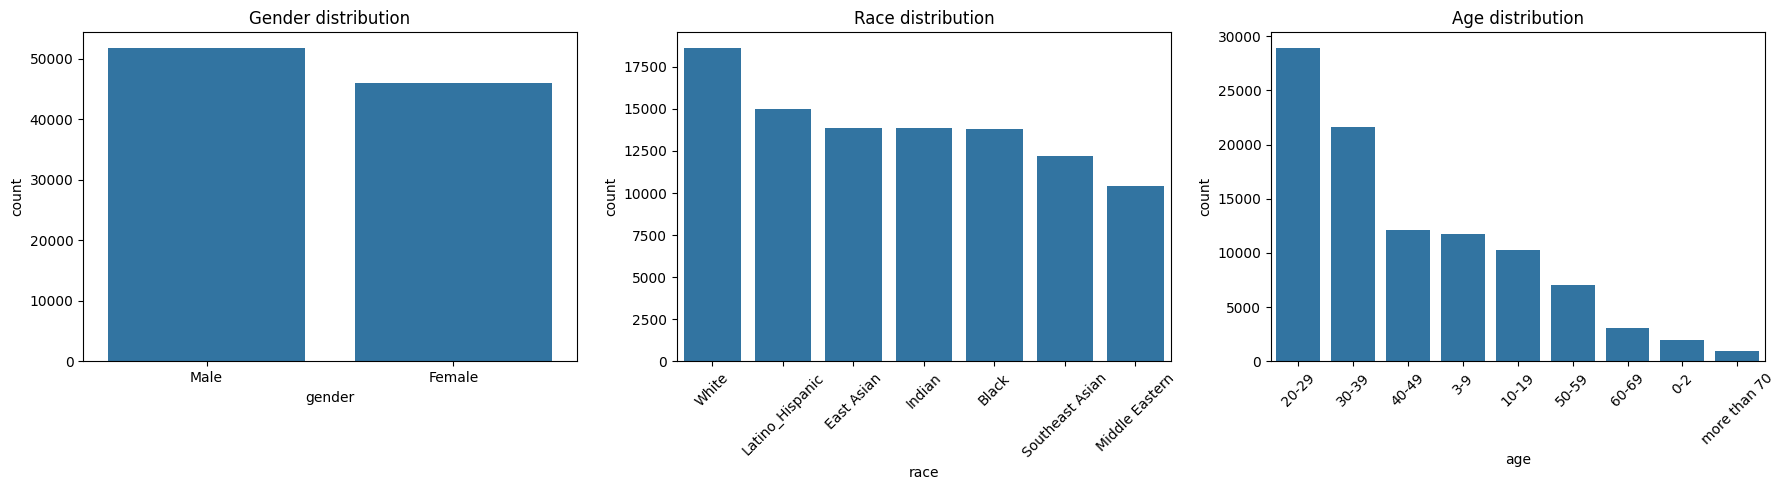

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 7: visualize group distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(data=df, x="gender", ax=axes[0])
axes[0].set_title("Gender distribution")

sns.countplot(data=df, x="race", order=df["race"].value_counts().index, ax=axes[1])
axes[1].set_title("Race distribution")
axes[1].tick_params(axis='x', rotation=45)

sns.countplot(data=df, x="age", order=df["age"].value_counts().index, ax=axes[2])
axes[2].set_title("Age distribution")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

gender           Female   Male
race                          
Black             0.500  0.500
East Asian        0.500  0.500
Indian            0.482  0.518
Latino_Hispanic   0.503  0.497
Middle Eastern    0.311  0.689
Southeast Asian   0.480  0.520
White             0.472  0.528


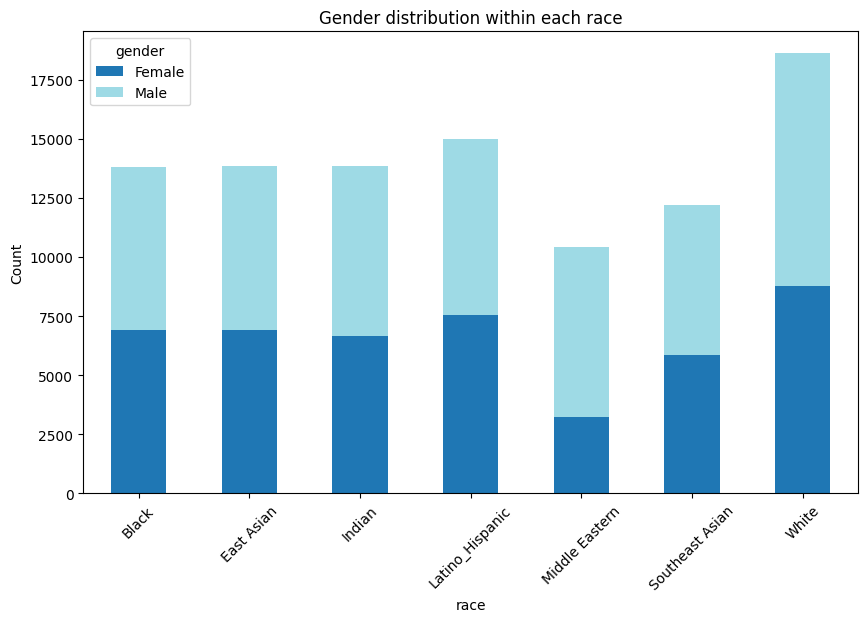

In [ ]:
# Step 8: Gender × Race cross-tab
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Build cross-tab of gender vs race
gender_race_ct = pd.crosstab(df["race"], df["gender"], normalize="index").round(3)
print(gender_race_ct)

# Visualize as a stacked bar chart
gender_race_counts = pd.crosstab(df["race"], df["gender"])
gender_race_counts.plot(kind="bar", stacked=True, figsize=(10,6), colormap="tab20")
plt.title("Gender distribution within each race")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

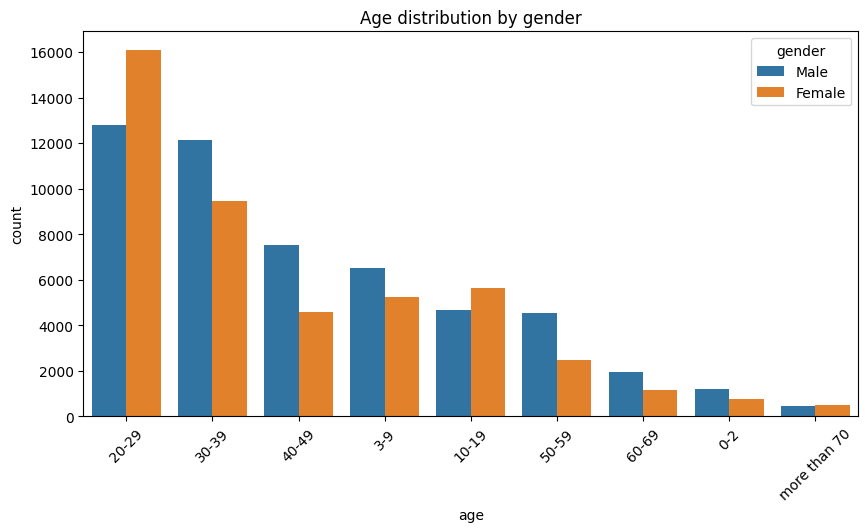

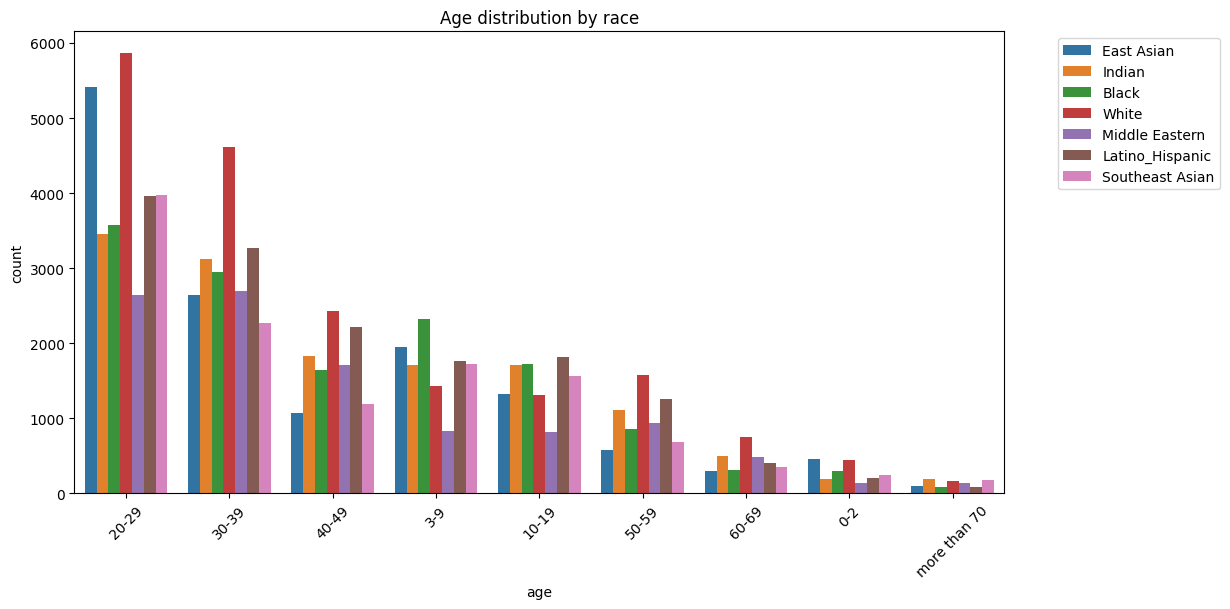

In [ ]:
# Step 9: Age distributions by subgroup
import seaborn as sns
import matplotlib.pyplot as plt

# Plot age distribution by gender
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="age", hue="gender", order=df["age"].value_counts().index)
plt.title("Age distribution by gender")
plt.xticks(rotation=45)
plt.show()

# Plot age distribution by race
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="age", hue="race", order=df["age"].value_counts().index)
plt.title("Age distribution by race")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
# Step 10: check correlations and statistical associations
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Encode categorical attributes numerically for correlation heatmap
encoded_df = df.copy()
encoded_df["gender_enc"] = encoded_df["gender"].astype("category").cat.codes
encoded_df["race_enc"]   = encoded_df["race"].astype("category").cat.codes
encoded_df["age_enc"]    = encoded_df["age"].astype("category").cat.codes

# Correlation matrix
corr = encoded_df[["gender_enc","race_enc","age_enc"]].corr()
print("Correlation matrix:\n", corr)

# Chi-square tests for independence
def chi_square_test(var1, var2):
    table = pd.crosstab(df[var1], df[var2])
    chi2, p, dof, ex = chi2_contingency(table)
    return chi2, p

print("\nChi-square tests:")
print("Gender vs Race:", chi_square_test("gender","race"))
print("Gender vs Age:", chi_square_test("gender","age"))
print("Race vs Age:", chi_square_test("race","age"))

Correlation matrix:
             gender_enc  race_enc   age_enc
gender_enc    1.000000  0.034786  0.118588
race_enc      0.034786  1.000000  0.059820
age_enc       0.118588  0.059820  1.000000

Chi-square tests:
Gender vs Race: (1236.24430748608, 6.84673175944955e-264)
Gender vs Age: (2196.943480159212, 0.0)
Race vs Age: (3766.1124228413123, 0.0)


In [ ]:
# Step 11: check if 'service_test' is correlated with sensitive attributes
print("Service_test distribution:\n", df["service_test"].value_counts(normalize=True))

# Cross-tab service_test vs gender
print("\nService_test vs Gender:")
print(pd.crosstab(df["service_test"], df["gender"], normalize="index").round(3))

# Cross-tab service_test vs race
print("\nService_test vs Race:")
print(pd.crosstab(df["service_test"], df["race"], normalize="index").round(3))

# Cross-tab service_test vs age
print("\nService_test vs Age:")
print(pd.crosstab(df["service_test"], df["age"], normalize="index").round(3).head(10))

Service_test distribution:
 service_test
False    0.535159
True     0.464841
Name: proportion, dtype: float64

Service_test vs Gender:
gender        Female   Male
service_test               
False          0.445  0.555
True           0.499  0.501

Service_test vs Race:
race          Black  East Asian  Indian  Latino_Hispanic  Middle Eastern  \
service_test                                                               
False         0.140       0.141   0.141            0.163           0.075   
True          0.143       0.143   0.143            0.143           0.143   

race          Southeast Asian  White  
service_test                          
False                   0.110  0.231  
True                    0.142  0.143  

Service_test vs Age:
age             0-2  10-19  20-29    3-9  30-39  40-49  50-59  60-69  \
service_test                                                           
False         0.030  0.093  0.228  0.145  0.232  0.134  0.088  0.038   
True          0.009  0.119  0.3

Representation Bias

Gender: Balanced (≈53% male, 47% female). Little concern here.

Race: Uneven — White (~19%) is the largest group, while Middle Eastern (~11%) and Southeast Asian (~12%) are smaller.

Age: Strong skew toward younger adults (20–39 = ~52%). Seniors (60+ = <5%) and infants (0–2 = ~2%) are underrepresented.

Risk: Underrepresented race/age groups may see higher misclassification error rates.

Intersectional Bias

Gender × Race: Some racial groups skew more male or female, introducing imbalance.

Age × Gender / Race: Younger ages dominate across groups, but seniors appear very rarely in some subgroups (e.g., older women of certain races nearly absent).

Risk: Intersectional blind spots — e.g., poor performance on older minority women.

Correlation / Proxy Bias

Chi-square tests: All sensitive attribute pairs (Gender–Race, Gender–Age, Race–Age) are not independent (p < 0.05).

Implication: A model trained to predict one label (say, gender) may inadvertently rely on correlated attributes (race or age).

Proxy features: service_test flag could encode group information (to be confirmed by its distribution), creating indirect bias channels.

Risk: Hidden bias creep — models may latch onto correlated or proxy features.

Sampling Bias

Train/Val splits: If certain subgroups are disproportionately placed into train or validation sets, model evaluation may give a false sense of fairness.

Risk: Misleading fairness metrics during evaluation.

Overall

This exploratory analysis suggests that while gender balance is good, age imbalance and race entanglements create the main bias risks. These will guide which fairness metrics to apply (e.g., subgroup accuracy, worst-group accuracy) and which mitigation methods in VB-Mitigator will be most relevant (e.g., Group DRO to improve worst-case group performance).